# Connecting to a GPU server
There is 48 A16 GPUs on the newly setup GPUcluster.
<br>[gpu.fel.cvut.cz](https://gpu.fel.cvut.cz/)

Several ways of connecting to it:
- Jupyter notebook session
- VSCode server
- Virtual Desktop
- direct ssh + allocate GPU with slurm (requires to be on uni network)

### Directly connecting through ssh
`ssh username@gpu.fel.cvut.cz`

### Allocating a GPU
`srun -p fast --gres=gpu:1 --pty bash -i`

### Mounting the disk to local filesystem
`sshfs username@gpu.fel.cvut.cz:/home.nfs/username local_folder`

### Python packages
The gpu servers have up-to-date Python, PyTorch, NumPy, Matplotlib, etc.. libraries pre-installed. We recommend you stick to those, if you need something extra feel free to install it with pip or load with `ml load <package_name>`, but be careful, as the given package might not be installed in BRUTE.

# Defining a custom dataset

In [1]:
import torch, torch.nn as nn, torch.functional as F
import numpy as np
import torchvision
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [2]:
image_transform = transforms.Compose([
                        transforms.Resize(128),
                        transforms.CenterCrop(128),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                    ])

mask_transform = transforms.Compose([
                        transforms.Resize(128),
                        transforms.CenterCrop(128),
                    ])

In [3]:
class PetsDataset(Dataset):
    def __init__(self, dataset_path):
        self.image_paths = sorted(list(Path(dataset_path / "images").iterdir())) # list of paths to individual images
        self.map_paths = sorted(list(Path(dataset_path / "trimaps").iterdir())) # list of paths to individual annotation files

        assert len(self.image_paths) == len(self.map_paths)
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = image_transform(image)
        
        mask = Image.open(self.map_paths[idx])
        mask = mask_transform(mask)
        mask = torch.tensor(np.array(mask)).long() - 1
        return image, mask

In [4]:
dataset_path = Path("/mnt/datasets/urob/pets/")
dataset = PetsDataset(dataset_path)

In [5]:
val_set_coef = 0.1
trainset_size = int(len(dataset) - val_set_coef * len(dataset))
trainset, validset = torch.utils.data.random_split(dataset, [trainset_size, len(dataset) - trainset_size])
print(f"trainset_sz={len(trainset)}, validset_sz={len(validset)}")

trainset_sz=5948, validset_sz=661


In [6]:
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(validset, batch_size=8, shuffle=True, num_workers=4)

In [7]:
x, mask = next(iter(train_loader))
x.shape, mask.shape

(torch.Size([8, 3, 128, 128]), torch.Size([8, 128, 128]))

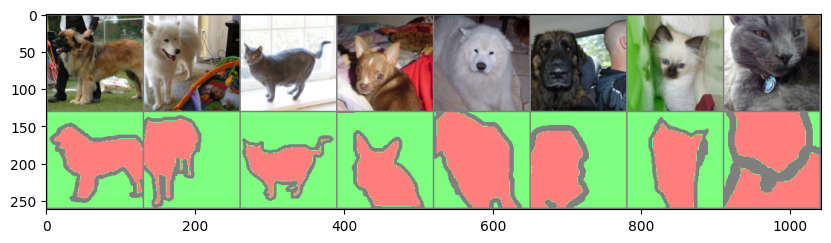

In [8]:
from torchvision.utils import make_grid

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def mask_to_img(mask):
    mask_img = torch.zeros((mask.shape[0], 128, 128, 3)).to(device)
    mask_img[mask == 0] = torch.tensor([1., 0., 0.], device=device)
    mask_img[mask == 1] = torch.tensor([0., 1., 0.], device=device)
    mask_img = mask_img.permute(0, 3, 1, 2)
    return mask_img

to_viz = torch.cat([x, mask_to_img(mask)], dim=0)

imshow(make_grid(to_viz))

# Transposed Convolution

# PyTorch LEGO (for segmentation)

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, padding=1):
        super(ConvBlock, self).__init__()
        self.layer = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel, padding=padding),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
    def forward(self, x):
        return self.layer(x)

class MLPBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(MLPBlock, self).__init__()
        self.layer = nn.Sequential(nn.Linear(in_dim, out_dim),
                                   nn.ReLU())
    def forward(self, x):
        return self.layer(x)

class TransConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(TransConvBlock, self).__init__()
        self.layer = nn.Sequential(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
                                   nn.ReLU())
    def forward(self, x):
        return self.layer(x)

print(ConvBlock(3, 6))
print(MLPBlock(32, 64))
print(TransConvBlock(32, 64))

ConvBlock(
  (layer): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
MLPBlock(
  (layer): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
  )
)
TransConvBlock(
  (layer): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
)


In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128)
        )

        self.mlp = nn.Sequential(
            MLPBlock(16*16*128, 128),
            MLPBlock(128, 256),
            nn.Linear(256, 37)
        )

        self.segment_head = nn.Sequential(
            TransConvBlock(128, 64),
            TransConvBlock(64, 32),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        features_flat = torch.flatten(features, 1)
        print("features: ", features.shape)
        class_pred = self.mlp(features_flat)

        mask_pred = self.segment_head(features)
        print(mask_pred.shape)
        
        return class_pred, mask_pred

print(Net())

Net(
  (backbone): Sequential(
    (0): ConvBlock(
      (layer): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (layer): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (mlp): Sequential(
    (0): MLPBlock(
      (layer): Sequential(
        (0): Linear(in_features=32768, out_features=128, bias=True)
        (1): ReLU()
      )
    )
    (1): MLPBlock(
      (layer): Sequential(
      

In [11]:
net = Net()
breed_pred, mask_pred = net(torch.randn(8, 3, 128, 128))
print(f"{breed_pred.shape=}, {mask_pred.shape=}")

features:  torch.Size([8, 128, 16, 16])
torch.Size([8, 3, 128, 128])
breed_pred.shape=torch.Size([8, 37]), mask_pred.shape=torch.Size([8, 3, 128, 128])


In [12]:
mask.shape, mask_pred.shape

(torch.Size([8, 128, 128]), torch.Size([8, 3, 128, 128]))

In [13]:
# how we compute classification loss
loss_fn = nn.CrossEntropyLoss()
fake_label = torch.zeros((8,)).long()
classif_loss = loss_fn(breed_pred, fake_label)
print(f"loss=", classif_loss)

loss= tensor(3.5573, grad_fn=<NllLossBackward0>)


In [14]:
# how to compute mask loss
mask_loss = loss_fn(mask_pred, mask)
print(f"loss=", mask_loss)

loss= tensor(1.1243, grad_fn=<NllLoss2DBackward0>)
